In [0]:
#Adapted from sources:

# https://www.tensorflow.org/tutorials/images/transfer_learning
# https://www.tensorflow.org/tutorials/load_data/images

#Data provided from 95-891 CMU Course.



from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
import shutil, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

AUTOTUNE=tf.data.experimental.AUTOTUNE



TensorFlow 2.x selected.


In [0]:
tf.__version__


'2.1.0'

In [0]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Num GPUs Available:  1
Found GPU at: /device:GPU:0


In [0]:
# # from https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=Y04m-jvKRDsJ

# import timeit

# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   print(
#       '\n\nThis error most likely means that this notebook is not '
#       'configured to use a GPU.  Change this in Notebook Settings via the '
#       'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
#   raise SystemError('GPU device not found')

# def cpu():
#   with tf.device('/cpu:0'):
#     random_image_cpu = tf.random.normal((100, 100, 100, 3))
#     net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
#     return tf.math.reduce_sum(net_cpu)

# def gpu():
#   with tf.device('/device:GPU:0'):
#     random_image_gpu = tf.random.normal((100, 100, 100, 3))
#     net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
#     return tf.math.reduce_sum(net_gpu)
  
# # We run each op once to warm up; see: https://stackoverflow.com/a/45067900
# cpu()
# gpu()

# # Run the op several times.
# print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
#       '(batch x height x width x channel). Sum of ten runs.')
# print('CPU (s):')
# cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
# print(cpu_time)
# print('GPU (s):')
# gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
# print(gpu_time)
# print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

In [0]:
# Getting the data and preprocessing

os.chdir("/content/drive/My Drive/HW3_AI/")

test = pd.read_csv('HW3_test.csv',header = None)
train = pd.read_csv('HW3_train.csv', header = None)
#id, url, landmark_id are columns
#id corresponds to name of .jpg
test.columns = ['id','url','landmark_id']
train.columns = ['id','url','landmark_id']

#removing URL column

test = test[['id','landmark_id']]
train = train[['id','landmark_id']]

#adding extension to id to match filenames
test['id'] = test['id'] + '.jpg'
train['id'] = train['id'] + '.jpg'


In [0]:
test.head()

,id,landmark_id
0,7e15276b0cbe4226.jpg,6
1,210384b6a647ac43.jpg,6
2,2a6b356a071e148d.jpg,5
3,3d92bd75d9691769.jpg,4
4,6bc5ddacc2bf537d.jpg,4


In [0]:
test.head()

,id,landmark_id
0,7e15276b0cbe4226.jpg,6
1,210384b6a647ac43.jpg,6
2,2a6b356a071e148d.jpg,5
3,3d92bd75d9691769.jpg,4
4,6bc5ddacc2bf537d.jpg,4


In [0]:
#preprocessing continued...
#subsetting images into proper folders per Transfer Learning Tutorial format
#
#This step is not necessary but is leveraging the same file structure as
# an earlier PyTorch implementation (wanted to have a single upload to Drive)

# def partition_images(landmarks):
#   for k,_ in enumerate(landmarks): #range over all labels
#       for _, row in test.iterrows():
#           if row.landmark_id == k:
#               shutil.copy(src = f'images/{row.id}', dst = f'data/val/{k}')

#   #copying train images
#   for k,_ in enumerate(landmarks): #range over all labels
#       for _, row in train.iterrows():
#           if row.landmark_id == k:
#               shutil.copy(src = f'images/{row.id}', dst = f'data/val/{k}')

In [0]:
landmarks = {0:"St. Stephan's Cathedral, Austria",
             1:"Teide, Spain",
             2:"Tallinn, Estonia",
             3:"Brugge, Belgium",
             4:"Montreal, Canada",
             5:"Itsukushima Shrine, Japan",
             6:"Shanghai, China",
             7:"Brisbane, Australia",
             8:"Edinburgh, Scotland",
             9:"Stockholm, Sweden"}

In [0]:
#data loading per https://www.tensorflow.org/tutorials/load_data/images

import pathlib
data_dir = 'data'
data_dir = pathlib.Path(data_dir)

# print(data_dir)
image_count = len(list(data_dir.glob('*/*/*.jpg')))
print(f'We have {image_count} images to classify.')



We have 57317 images to classify.


In [0]:
CLASS_NAMES = np.unique(np.array([item.name for item in data_dir.glob('*/*')]))
# get unique class names (would have double-counted across both train and val folders.)
CLASS_NAMES

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

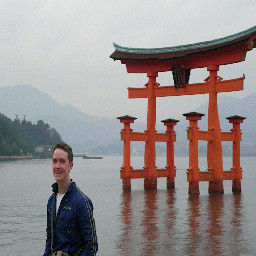

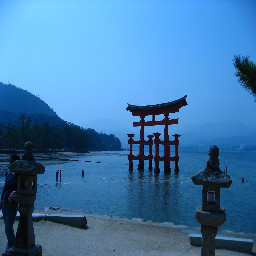

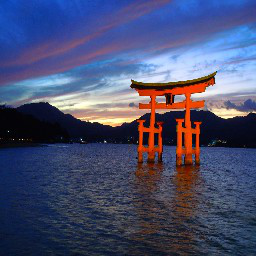

In [0]:
import IPython.display as display
from PIL import Image

japan = list(data_dir.glob('train/5/*'))
#some example images from training data.
for image_path in japan[:3]:
    display.display(Image.open(str(image_path)))

In [0]:
# Setting feature parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224


In [0]:
def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3) #color images
  img = tf.image.convert_image_dtype(img, tf.float32) 
   #convert unit8 tensor to floats in the [0,1]range
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT]) 
#resize the image into 224*224 

In [0]:
def get_label(file_path):
  parts = tf.strings.split(file_path, '/')
  return parts[-2] == CLASS_NAMES

In [0]:
def process_path(file_path):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [0]:
# Use Dataset.map to create a dataset of image, label pairs:

# list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*/*'))

raw_train_ds = tf.data.Dataset.list_files(str(data_dir/'train/*/*'))
raw_val_ds = tf.data.Dataset.list_files(str(data_dir/'val/*/*'))


# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
training = raw_train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
validation = raw_val_ds.map(process_path, num_parallel_calls=AUTOTUNE)


In [0]:
# train = raw_train.map(format_example)
# validation = raw_validation.map(format_example)
# test = raw_test.map(format_example)

In [0]:
# Example of image/label.

for image, label in training.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())
  id = np.argwhere(label.numpy()== True).flatten()[0]
  print(landmarks[id])

print('\n\n')

for image, label in validation.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())
  id = np.argwhere(label.numpy()== True).flatten()[0]
  print(landmarks[id])



Image shape:  (224, 224, 3)
Label:  [False False False False False False  True False False False]
Shanghai, China



Image shape:  (224, 224, 3)
Label:  [False False False False False False False False False  True]
Stockholm, Sweden


In [0]:
# shuffling/batching data
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
train_batches = training.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
# test_batches = test.batch(BATCH_SIZE)

In [0]:
# # Example batch

for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 224, 224, 3])

In [0]:
# Create the base model from the pre-trained model MobileNet V2

IMG_SHAPE = (IMG_HEIGHT,IMG_WIDTH,3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [0]:
# #example batch of features
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [0]:
base_model.trainable = False

In [0]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
# To generate predictions from the block of features,
#  average over the spatial 5x5 spatial locations, 
# using a tf.keras.layers.GlobalAveragePooling2D layer to 
# convert the features to a single 1280-element vector per image

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [0]:
#  convert these features into a ten predictions per image for a 10-sized logit tensor (one per class)

prediction_layer = tf.keras.layers.Dense(10)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


In [0]:
# Now stack the feature extractor, and these
#  two layers using a tf.keras.Sequential model:

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [0]:
# Compiling the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
#Train the model
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


20/20 [==============================] - 268s 13s/step - loss: 0.8715 - accuracy: 0.6255
initial loss: 0.87
initial accuracy: 0.63


In [0]:
history = model.fit(train_batches,
                    epochs=initial_epochs, 
                    validation_data=validation_batches)

Train for 844 steps, validate for 948 steps
Epoch 1/10
843/844 [============================>.] - ETA: 11s - loss: 0.2235 - accuracy: 0.9145